# Machine Learning (ML) From Scratch

<div class="questions">

### Questions

- How can I use Python for Machine learning?
- How to I wrange my data to work within an ML context?
- How do I assess whether my models fit well?
</div>

<div class="objectives">

### Objectives

- Use scikit-learn to solve a machine learning problem
</div>

Most machine learning problems begin with a dataset, but before we can perform any kind of inference on that dataset we must create/wrangle/build it. This is often the most time-consuming and hard part of a successful machine learning workflow. There is no set procedure here, as all data is different, although there are a few simple methods we can take to make a useful dataset.

Machine learning can be split into:

- Supervised learning, where we are trying to predict:

    - A numeric value such as a stock price, mineral quantity at a specific site etc. This is called "regression".
    - A categorical label, such as having/not having a specific disease, a response (such as "low", "medium", "high") etc. This is called "classification".

- Unsupervised learning, where we are trying to find groups in our data withouth specifying a particular outcome to split the dataset along.

We will be using data from a submitted Manuscript (Butterworth and Barnett-Moore 2020) which was a finalist in the [Unearthed, ExploreSA: Gawler Challenge](https://unearthed.solutions/u/competitions/exploresa). You can visit the [original repo here](https://github.com/natbutter/gawler-exploration).



# Building a dataset of "targets" and "predictor variables"

The targets in a supervised ML context can be a simple binary 1 or 0, or could be some category (classification), or the value of a particular parameter (regression problems). It is the "feature" of a dataset that we want to learn something about!

The "predictor/feature variables" are the qualities/parameters that may have some causal relationship with the "target".


## Step 1 - Determine our target variable
Let's explore our our main dataset.

### Deposit locations - mine and mineral occurrences
The most important dataset for this workflow is the currently known locations of mineral occurrences. Using the data we already know about these mineral deposits we will build a model to predict where future occurrences will be.

In [1]:
# For working with shapefiles (packaged is called pyshp)
import shapefile
# For working with dataframes
import pandas as pd

In [2]:
# Set the filename
mineshape="../data/MinesMinerals/mines_and_mineral_occurrences_all.shp"

# Set shapefile attributes and assign
sf = shapefile.Reader(mineshape)
fields = [x[0] for x in sf.fields][1:]
records = sf.records()
shps = [s.points for s in sf.shapes()]

# Write into a dataframe for easy use
df = pd.DataFrame(columns=fields, data=records)

View the metadata of the [South Australian all mines and mineral deposits](https://catalog.sarig.sa.gov.au/geonetwork/srv/eng/catalog.search#/metadata/a0e4b62c-ec88-44b8-a530-b4e744a6b414) to get a better understanding for what features we could use as a target.

In [3]:
#See what the dataframe looks like
print(df.columns)

#For clean printing to html drop columns that contains annoying / and \ chars.
#And set max columns
pd.options.display.max_columns = 8
df.drop(columns=['REFERENCE','O_MAP_SYMB'])

Index(['MINDEP_NO', 'DEP_NAME', 'REFERENCE', 'COMM_CODE', 'COMMODS',
       'COMMOD_MAJ', 'COMM_SPECS', 'GCHEM_ASSC', 'DISC_YEAR', 'CLASS_CODE',
       'OPER_TYPE', 'MAP_SYMB', 'STATUS_VAL', 'SIZE_VAL', 'GEOL_PROV',
       'DB_RES_RVE', 'DB_PROD', 'DB_DOC_IMG', 'DB_EXV_IMG', 'DB_DEP_IMG',
       'DB_DEP_FLE', 'COX_CLASS', 'REG_O_CTRL', 'LOC_O_CTRL', 'LOC_O_COM',
       'O_LITH_CDE', 'O_LITH01', 'O_STRAT_NM', 'H_LITH_CDE', 'H_LITH02',
       'H_STRAT_NM', 'H_MAP_SYMB', 'EASTING', 'NORTHING', 'ZONE', 'LONGITUDE',
       'LATITUDE', 'SVY_METHOD', 'HORZ_ACC', 'SRCE_MAP', 'SRCE_CNTRE',
       'COMMENTS', 'O_MAP_SYMB'],
      dtype='object')


,MINDEP_NO,DEP_NAME,COMM_CODE,COMMODS,...,HORZ_ACC,SRCE_MAP,SRCE_CNTRE,COMMENTS
0,5219,MOUNT DAVIES NO.2A,Ni,Nickel,...,2000.0,500k meis,,
1,52,ONE STONE,Ni,Nickel,...,500.0,71-385,,
2,8314,HINCKLEY RANGE,Fe,Iron,...,500.0,,,
3,69,KALKA,"V, ILM","Vanadium, Ilmenite",...,100.0,1 MILE,mgt polygon on digital map,
4,65,ECHIDNA,Ni,Nickel,...,20.0,50K GEOL,DH ECHIDNA PROSPECT,
...,...,...,...,...,...,...,...,...,...
8672,6937,YARINGA,QTZE,Quartzite,...,200.0,50k moc,fenced yard,
8673,4729,WELCHS,SCHT,Schist,...,20.0,50k topo,,
8674,4718,ARCADIAN,CLAY,Clay,...,5.0,Plan 1951-0327,Pit,
8675,1436,MCDONALD,Au,Gold,...,200.0,50k moc,qz float,


In [4]:
#We are building a model to target South Australia, so load in a map of it.
gawlshape = "../data/SA/SA_STATE_POLYGON_shp"
shapeRead = shapefile.Reader(gawlshape)
shapes = shapeRead.shapes()

#Save the boundary xy pairs in arrays we will use throughout the workflow
xval = [x[0] for x in shapes[1].points]
yval = [x[1] for x in shapes[1].points]

In [5]:
# Subset the data, for a single Mineral target
commname='Mn'

#Pull out all the occurences of the commodity and go from there
comm=df[df['COMM_CODE'].str.contains(commname)]
comm=comm.reset_index(drop=True)
print("Shape of "+ commname, comm.shape)

# Can make further subsets of the data here if needed
#commsig=comm[comm.SIZE_VAL!="Low Significance"]
#comm=comm[comm.SIZE_VAL!="Low Significance"]
#comm=comm[comm.COX_CLASS == "Olympic Dam Cu-U-Au"]
#comm=comm[(comm.lon<max(xval)) & (comm.lon>min(xval)) & (comm.lat>min(yval)) & (comm.lat<max(yval))]


Shape of Mn (115, 43)


In [6]:
# For plotting
import matplotlib.pyplot as plt

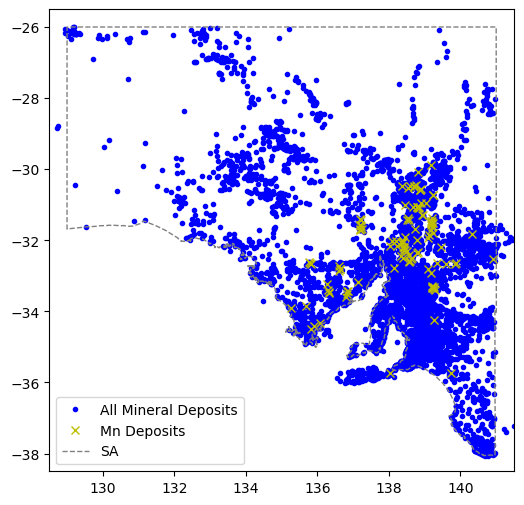

In [7]:
fig = plt.figure(figsize=(6,6))
ax = plt.axes()
ax.plot(df.LONGITUDE,df.LATITUDE,'b.',label="All Mineral Deposits")
ax.plot(comm.LONGITUDE,comm.LATITUDE,'yx',label=commname+" Deposits")

ax.plot(xval,yval,'grey',linestyle='--',linewidth=1,label='SA')
#ax.plot(comm.LONGITUDE, comm.LATITUDE, marker='o', linestyle='',markersize=5, color='y',label=commname+" Deposits")

plt.xlim(128.5,141.5)
plt.ylim(-38.5,-25.5)
plt.legend(loc=3)

plt.show()

## Step 2 - Wrangle the geophysical and geological datasets (predictor variables)
Many geophysical data are available for South Australia overlapping our target mineral locations. We may presume that certain mineral occurrences express a combination of geology and geophysics. We can train an algorithm to learn these associations and then use the same algorithm to make predictions for where unknown occurrences may be found. 

Here we load in the (slightly) pre-processed geophysical datasets and prepare them for further manipulations, data-mining, and machine learning. All of the full/raw datasets are available from https://map.sarig.sa.gov.au/. For this exercise we have simplified the datasets by reducing complexity and resolution. Grab additional processed datasets from [https://github.com/natbutter/gawler-exploration/tree/master/ML-DATA](https://github.com/natbutter/gawler-exploration/tree/master/ML-DATA)

### Resistivity xyz data

In [8]:
#Read in the data
data_res=pd.read_csv(
    "../data/AusLAMP_MT_Gawler_25.xyzr",
    sep=',',header=0,names=['lat','lon','depth','resistivity']
)
data_res

,lat,lon,depth,resistivity
0,-27.363931,128.680796,-25.0,2.0007
1,-27.659362,128.662322,-25.0,1.9979
2,-27.886602,128.647965,-25.0,1.9948
3,-28.061394,128.636833,-25.0,1.9918
4,-28.195844,128.628217,-25.0,1.9885
...,...,...,...,...
11003,-35.127716,142.399588,-25.0,2.0079
11004,-35.230939,142.408396,-25.0,2.0084
11005,-35.365124,142.419903,-25.0,2.0085
11006,-35.539556,142.434958,-25.0,2.0076


This data is the Lat-Lon spatial location and the value of the feature at that location.

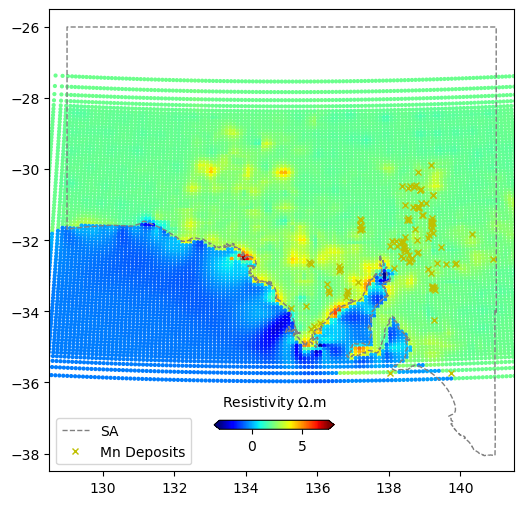

In [9]:
fig = plt.figure(figsize=(6,6))
ax = plt.axes()
im = ax.scatter(data_res.lon,data_res.lat,s=4,c=data_res.resistivity,cmap="jet")
ax.plot(xval,yval,'grey',linestyle='--',linewidth=1,label='SA')
ax.plot(comm.LONGITUDE, comm.LATITUDE, marker='x', linestyle='',markersize=5, color='y',label=commname+" Deposits")

plt.xlim(128.5,141.5)
plt.ylim(-38.5,-25.5)
plt.legend(loc=3)

cbaxes = fig.add_axes([0.40, 0.18, 0.2, 0.015])
cbar = plt.colorbar(im, cax = cbaxes,orientation="horizontal",extend='both')
cbar.set_label('Resistivity $\Omega$.m', labelpad=10)
cbar.ax.xaxis.set_label_position('top')

plt.show()

### Faults and dykes vector polylines

In [10]:
# For dealing with arrays 
import numpy as np

In [11]:
#Get fault data neo
faultshape = "../data/Faults/Faults.shp"
shapeRead = shapefile.Reader(faultshape)
shapes = shapeRead.shapes()
Nshp = len(shapes)

# Initialise an empty list
faultsNeo = []
for i in range(0,Nshp):
    for j in shapes[i].points:
        faultsNeo.append([j[0],j[1]])

#Convert list to array
faultsNeo = np.array(faultsNeo)
faultsNeo

array([[133.46269605, -27.41825034],
       [133.46770683, -27.42062991],
       [133.4723624 , -27.42259841],
       ...,
       [138.44613353, -35.36560605],
       [138.44160669, -35.36672662],
       [138.43805501, -35.36793484]])

This data is just a Lat-Lon location. Think how we can use this in a model.

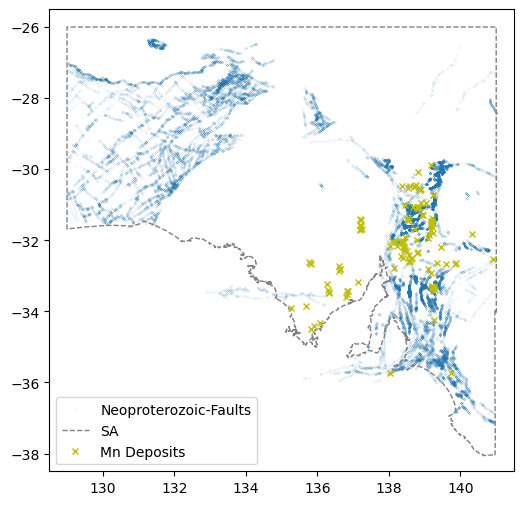

In [12]:
fig = plt.figure(figsize=(6,6))
ax = plt.axes()
plt.plot(faultsNeo[:,0],faultsNeo[:,1],'.',markersize=0.1,label="Neoproterozoic-Faults")
ax.plot(xval,yval,'grey',linestyle='--',linewidth=1,label='SA')
ax.plot(comm.LONGITUDE, comm.LATITUDE, marker='x', linestyle='',markersize=5, color='y',label=commname+" Deposits")

plt.xlim(128.5,141.5)
plt.ylim(-38.5,-25.5)
plt.legend(loc=3)

plt.show()

### Netcdf formatted raster grids - geophysics

In [13]:
# For timing events
import time
# For making grids and reading netcdf data
import scipy
import scipy.io

In [14]:
#Define a function to read the netcdf files
def read_netcdf(filename):
    tic = time.time()
    data = scipy.io.netcdf_file(filename, 'r', mmap=False)
    x_data = data.variables['lon'][:]
    y_data = data.variables['lat'][:]
    z_data = np.array(data.variables['Band1'][:])
    data.close()
    
    toc = time.time()
    print("Loaded", filename, "in", f'{toc - tic:.2f}s')
    print("Spacing x", f'{x_data[2] - x_data[1]:.2f}', 
          "y", f'{y_data[2] - y_data[1]:.2f}', 
          "Shape:", np.shape(z_data), "Min x:", np.min(x_data), "Max x:", np.max(x_data),
          "Min y:", np.min(y_data), f'Max y {np.max(y_data):.2f}')

    data_dic = {
        'x_data': x_data,
        'y_data': y_data,
        'z_data': z_data,
        'origin_x': np.min(x_data),
        'origin_y': np.min(y_data),
        'pixel_x': x_data[2] - x_data[1],
        'pixel_y': y_data[2] - y_data[1]
    }
    
    return data_dic

In [15]:
# Digital Elevation Model
data_dem = read_netcdf("../data/sa-dem.nc")
# Total Magnetic Intensity
data_mag = read_netcdf("../data/sa-mag-tmi.nc")
# Gravity
data_grav = read_netcdf("../data/sa-grav.nc")

Loaded ../data/sa-dem.nc in 0.01s
Spacing x 0.01 y 0.01 Shape: (1208, 1201) Min x: 129.005 Max x: 141.005 Min y: -38.065 Max y -25.99
Loaded ../data/sa-mag-tmi.nc in 0.01s
Spacing x 0.01 y 0.01 Shape: (1208, 1201) Min x: 129.005 Max x: 141.005 Min y: -38.065 Max y -25.99
Loaded ../data/sa-grav.nc in 0.01s
Spacing x 0.01 y 0.01 Shape: (1208, 1201) Min x: 129.005 Max x: 141.005 Min y: -38.065 Max y -25.99


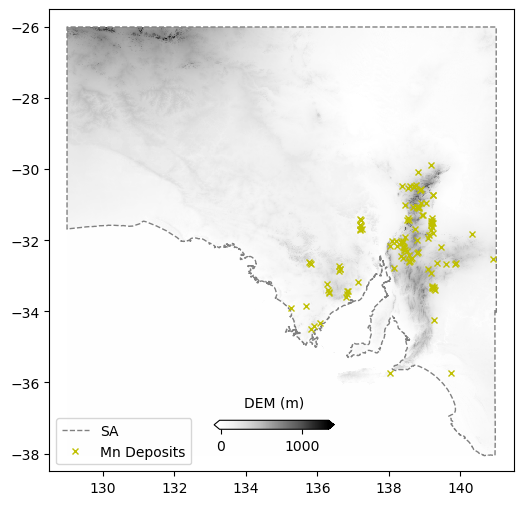

In [16]:
fig = plt.figure(figsize=(6,6))
ax = plt.axes()
im = plt.pcolormesh(data_dem["x_data"],data_dem["y_data"],data_dem["z_data"],cmap='Greys',shading='auto')
ax.plot(xval,yval,'grey',linestyle='--',linewidth=1,label='SA')
ax.plot(comm.LONGITUDE, comm.LATITUDE, marker='x', linestyle='',markersize=5, color='y',label=commname+" Deposits")

plt.xlim(128.5,141.5)
plt.ylim(-38.5,-25.5)
plt.legend(loc=3)

cbaxes = fig.add_axes([0.40, 0.18, 0.2, 0.015])
cbar = plt.colorbar(im, cax = cbaxes,orientation="horizontal",extend='both')
cbar.set_label('DEM (m)', labelpad=10)
cbar.ax.xaxis.set_label_position('top')

plt.show()

These data are raster grids. Essentially Lat-Lon-Value like the XYZ data, but represented in a different format.

### Categorical Geology in vector polygons

In [17]:
#Archean basement geology
geolshape = shapefile.Reader("../data/Archaean_Early_Mesoprterzoic_polygons_shp/geology_archaean.shp")
recsArch = geolshape.records()
shapesArch = geolshape.shapes()

In [18]:
# Print the field names in the shapefile
for i,field in enumerate(geolshape.fields):
    print(i-1,field[0]) 

-1 DeletionFlag
0 MAJORSTRAT
1 SG_DESCRIP
2 MAPUNIT
3 SG_PROVINC
4 DOMAIN
5 AGE
6 SEQUSET
7 PRIMARYAGE
8 OROGENYAGE
9 INHERITAGE
10 STRATNO
11 STRATNAME
12 STRATDESC
13 GISCODE
14 SUBDIVNAME
15 SUBDIVSYMB
16 PROVINCE
17 MAXAGE
18 MAXMOD
19 MAXMETH
20 MINAGE
21 MINMOD
22 MINMETH
23 GLCODE


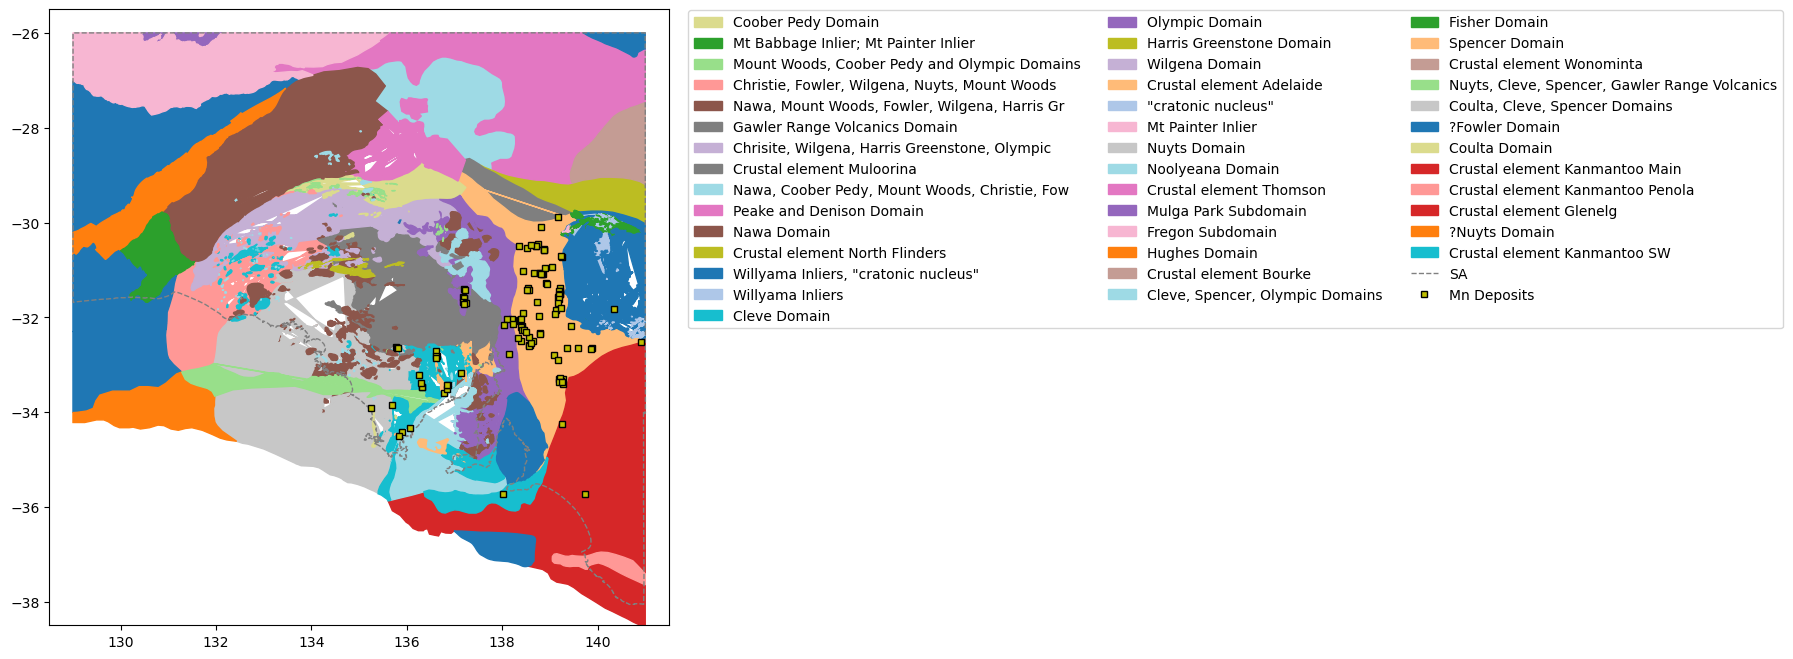

In [19]:
fig = plt.figure(figsize=(8,8))
ax = plt.axes()

#index of the geology unit #4 #10 #12
geoindex = 4
#Gather all the unique Major Geology unit numbers
labs=[]
for i in recsArch:
    labs.append(i[geoindex])

geols = list(set(labs))

# Create a unique color for each geological unit label
color = plt.cm.tab20(np.linspace(0, 1, len(geols)))
cdict={}
for i, geol in enumerate(geols):
    cdict.update({geol:color[i]})
    
#Plot each of the geology polygons
for i in range(len(shapesArch)):
    boundary = shapesArch[i].points
    xs = [x for x, y in shapesArch[i].points]
    ys = [y for x, y in shapesArch[i].points]
    c = cdict[recsArch[i][geoindex]]
    ax.fill(xs,ys,c=c,label=recsArch[i][geoindex])
      
#Plot the extra stuff
ax.plot(xval,yval,'grey',linestyle='--',linewidth=1,label='SA')
ax.plot(
    comm.LONGITUDE, 
    comm.LATITUDE, 
    marker='s', 
    markeredgecolor='k', 
    linestyle='',
    markersize=4, 
    color='y',
    label=commname+" Deposits"
       )

#Legend without duplicate values
handles, labels = ax.get_legend_handles_labels()
unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
ax.legend(*zip(*unique), bbox_to_anchor = (1.02, 1.01), ncol=3)

plt.xlim(128.5,141.5)
plt.ylim(-38.5,-25.5)

plt.show()

**Take a moment to appreciate the various methods you have used just to load the data!**

Now we need to think about what we actually want to achieve? What is our goal here? This will determine what kind of data analysis/manipulation we need to make here. Consider the flow diagram for [choosing the right machine learning method](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html).

## Step 3 - Assign geophys values to target locations

We need to assign the values of each of these geophysical datasets (predictor variables) to the target class (i.e. mineral deposit locations). 
The assumption being that the occurrence of some mineral deposit (e.g. Cu) is a function of x1, x2, x3, x4, x5, x6. 
Where the Resistivity is x1, the distance to a Neoprotezoic fault is x2, the value of DEM, magnetic TMI, and Gravity is x3, x4, and x5, and the geological basement unit is x6.

In [20]:
# Make a Target DataFrame of the points we want to interrogate the features for
td1 = comm[['LONGITUDE', 'LATITUDE']].copy()

### Resistivity

In [21]:
# For making KD Trees
import scipy.spatial

In [22]:
# Define a function which "coregisters" a point from a bunch of other points.
def coregPoint(tree,point,region,retval='index'):
    '''
    Finds the nearest neighbour to a point from a bunch of other points
    tree - a scipy CKTree to search for the point over
    point - array([longitude,latitude])
    region - integer, same units as data
    '''
    dists, indexes = tree.query(point,k=1,distance_upper_bound=region) 

    if retval=='index':
        return (indexes)
    elif retval=='dists':
        return(dists)
    

In [23]:
# Find the values of the resetivity grid for each lat/lon deposit location.

# Make a search-tree of the point-pairs for fast lookup of nearest matches
treeres = scipy.spatial.cKDTree(np.c_[data_res.lon,data_res.lat])

# Perform the search for each point
indexes = td1.apply(
    lambda x: coregPoint(treeres,np.array([x.LONGITUDE, x.LATITUDE]),1,retval='index'), axis=1)

In [24]:
td1['res'] = data_res.loc[indexes].resistivity.values
td1

,LONGITUDE,LATITUDE,res
0,139.179436,-29.877637,2.2135
1,138.808767,-30.086296,2.3643
2,138.752281,-30.445684,2.1141
3,138.530506,-30.533225,2.2234
4,138.887019,-30.565479,2.1982
...,...,...,...
110,136.059715,-34.327929,3.4926
111,138.016821,-35.733084,2.0868
112,139.250036,-34.250155,1.9811
113,135.905480,-34.425866,2.7108


### Faults

In [25]:
#Same for the fault data 
# but this time we get the "distance to the point", rather than the value at that point.
treefaults = scipy.spatial.cKDTree(faultsNeo)

dists = td1.apply(
    lambda x: coregPoint(treefaults,np.array([x.LONGITUDE, x.LATITUDE]),100,retval='dists'), axis=1)

In [26]:
td1['faults'] = dists
td1

,LONGITUDE,LATITUDE,res,faults
0,139.179436,-29.877637,2.2135,0.010691
1,138.808767,-30.086296,2.3643,0.103741
2,138.752281,-30.445684,2.1141,0.006659
3,138.530506,-30.533225,2.2234,0.013925
4,138.887019,-30.565479,2.1982,0.007356
...,...,...,...,...
110,136.059715,-34.327929,3.4926,0.526835
111,138.016821,-35.733084,2.0868,0.002451
112,139.250036,-34.250155,1.9811,0.027837
113,135.905480,-34.425866,2.7108,0.670323


### Geophysics

In [27]:
# Define a function which "coregisters" a point within a raster.
def get_coords_at_point(originx,originy,pixelx,pixely,lon,lat):
    '''
    Given a point in some coordinate reference (e.g. lat/lon)
    Find the closest point to that in an array (e.g. a raster)
    and return the index location of that point in the raster.
    INPUTS
        "output from "gdal_data.GetGeoTransform()"
    originx: first point in first axis
    originy: first point in second axis
    pixelx: difference between x points
    pixely: difference between y points
    
    lon: x/row-coordinate of interest
    lat: y/column-coordinate of interest
    
    RETURNS
    col: x index value from the raster
    row: y index value from the raster
    '''
    row = int((lon - originx)/pixelx)
    col = int((lat - originy)/pixely)

    return (col, row)


# Pass entire array of latlon and raster info to us in get_coords_at_point
def rastersearch(latlon,raster,originx,originy,pixelx,pixely):
    zlist=[]
    for lon,lat in zip(latlon.LONGITUDE,latlon.LATITUDE):
        try:
            zlist.append(raster[get_coords_at_point(originx,originy,pixelx,pixely,lon,lat)])
        except:
            zlist.append(np.nan)
            
    return(zlist)

In [28]:
td1['dem'] = rastersearch(td1,data_dem["z_data"],data_dem["origin_x"],data_dem["origin_y"],data_dem["pixel_x"],data_dem["pixel_y"])
td1['mag'] = rastersearch(td1,data_mag["z_data"],data_mag["origin_x"],data_mag["origin_y"],data_mag["pixel_x"],data_mag["pixel_y"])
td1['grav'] = rastersearch(td1,data_grav["z_data"],data_grav["origin_x"],data_grav["origin_y"],data_grav["pixel_x"],data_grav["pixel_y"])

In [29]:
td1

,LONGITUDE,LATITUDE,res,faults,dem,mag,grav
0,139.179436,-29.877637,2.2135,0.010691,187.297424,-118.074890,1.852599
1,138.808767,-30.086296,2.3643,0.103741,179.499237,-209.410507,-12.722121
2,138.752281,-30.445684,2.1141,0.006659,398.336823,-159.566422,-6.249788
3,138.530506,-30.533225,2.2234,0.013925,335.983429,-131.176437,-11.665316
4,138.887019,-30.565479,2.1982,0.007356,554.278198,-192.363297,-1.025702
...,...,...,...,...,...,...,...
110,136.059715,-34.327929,3.4926,0.526835,45.866119,-244.067841,11.410070
111,138.016821,-35.733084,2.0868,0.002451,145.452789,-203.566940,18.458364
112,139.250036,-34.250155,1.9811,0.027837,276.489319,-172.889587,-1.714886
113,135.905480,-34.425866,2.7108,0.670323,162.431747,569.713684,15.066316


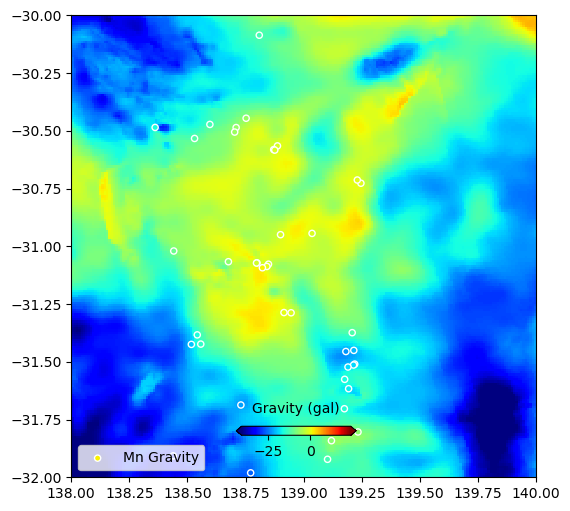

In [30]:
# Check we got it right.
# Plot a grid, and our interrogated points

fig = plt.figure(figsize=(6,6))
ax = plt.axes()
im = plt.pcolormesh(
    data_grav["x_data"],data_grav["y_data"],data_grav["z_data"],
    cmap='jet',shading='auto',vmin=min(td1.grav),vmax=max(td1.grav)
)
#ax.plot(xval,yval,'grey',linestyle='--',linewidth=1,label='SA')
#ax.plot(comm.LONGITUDE, comm.LATITUDE, marker='o', linestyle='',markersize=5, color='y',label=commname+" Deposits")

ax.scatter(td1.LONGITUDE, td1.LATITUDE, s=20, c=td1.grav,
           label=commname+" Gravity",cmap='jet',vmin=min(td1.grav),vmax=max(td1.grav),edgecolors='white')

plt.xlim(138,140)
plt.ylim(-32,-30)
plt.legend(loc=3)

cbaxes = fig.add_axes([0.40, 0.18, 0.2, 0.015])
cbar = plt.colorbar(im, cax = cbaxes,orientation="horizontal",extend='both')
cbar.set_label('Gravity (gal)', labelpad=10)
cbar.ax.xaxis.set_label_position('top')

plt.show()

### Geology

In [31]:
# For dealing with shapefile components
from shapely.geometry import Point, shape

# Make all the polygons into a list for fast access in the function
shape_objects = [shape(shp) for shp in shapesArch]
               
# #Define a function to find what polygon a point lives inside (speed imporivements can be made here)
def shapeExplore(lon,lat,shape_objects,recs):
    record_of_interest_index = 4
    #'record' is the column index you want returned
    for i, polygon in enumerate(shape_objects):
        if Point((lon,lat)).within(polygon):
            return(recs[i][record_of_interest_index])
    #if you have been through the loop with no result
    return('-9999')

In [32]:
%%time
td1['geol'] = td1.apply(lambda x: shapeExplore(x.LONGITUDE, x.LATITUDE, shape_objects,recsArch), axis=1)

CPU times: user 791 ms, sys: 4.59 ms, total: 795 ms
Wall time: 804 ms


In [33]:
td1

,LONGITUDE,LATITUDE,res,faults,dem,mag,grav,geol
0,139.179436,-29.877637,2.2135,0.010691,187.297424,-118.074890,1.852599,Crustal element Muloorina
1,138.808767,-30.086296,2.3643,0.103741,179.499237,-209.410507,-12.722121,Crustal element Adelaide
2,138.752281,-30.445684,2.1141,0.006659,398.336823,-159.566422,-6.249788,Crustal element Adelaide
3,138.530506,-30.533225,2.2234,0.013925,335.983429,-131.176437,-11.665316,Crustal element Adelaide
4,138.887019,-30.565479,2.1982,0.007356,554.278198,-192.363297,-1.025702,Crustal element Adelaide
...,...,...,...,...,...,...,...,...
110,136.059715,-34.327929,3.4926,0.526835,45.866119,-244.067841,11.410070,"Cleve, Spencer, Olympic Domains"
111,138.016821,-35.733084,2.0868,0.002451,145.452789,-203.566940,18.458364,Crustal element Kanmantoo SW
112,139.250036,-34.250155,1.9811,0.027837,276.489319,-172.889587,-1.714886,Crustal element Kanmantoo Main
113,135.905480,-34.425866,2.7108,0.670323,162.431747,569.713684,15.066316,Cleve Domain


**Congrats, you now have an ML dataset ready to go!**

Almost... but what is the target? Let's make a binary classifier.

## Step 4 - Generate a "non-deposit" dataset
We have a set of locations where a certain mineral deposit occurs along with the values of various geophysical parameters at those locations. To identify what values of the geophysics are associated with a mineral deposit then we need a representation of the "background noise" of those parameters, i.e. what the values are when there is no mineral deposit.

This step is important. There are numerous ways to generate our non-deposit set, each with different benefits and trade-offs. The randomisation of points throughout *some* domain appears to be robust. But you must think, is this domain a reasonable estimation of "background" geophysics/geology? Why are you picking these locations as non-deposits? Will they be over/under-representing actual deposits? Will they be over/under-representing actual non-deposits?

In [34]:
#Now make a set of "non-deposits" using a random location within our exploration area
lats_rand = np.random.uniform(low=min(df.LATITUDE), high=max(df.LATITUDE), size=len(comm.LATITUDE))
lons_rand = np.random.uniform(low=min(df.LONGITUDE), high=max(df.LONGITUDE), size=len(comm.LONGITUDE))

print("Produced", len(lats_rand),len(lons_rand), "latitude-longitude pairs for non-deposits.")

Produced 115 115 latitude-longitude pairs for non-deposits.


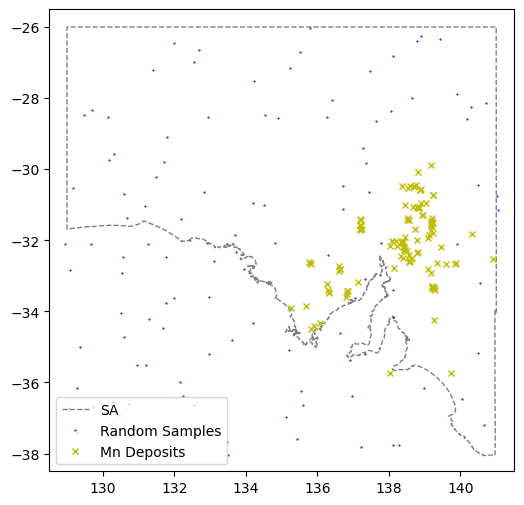

In [35]:
# Where are these randomised "non deposits"
fig = plt.figure(figsize=(6,6))
ax = plt.axes()

ax.plot(xval,yval,'grey',linestyle='--',linewidth=1,label='SA')

ax.plot(lons_rand, lats_rand, 
        marker='.', linestyle='',markersize=1, color='b',label="Random Samples")

ax.plot(td1.LONGITUDE, td1.LATITUDE, 
        marker='x', linestyle='',markersize=5, color='y',label=commname+" Deposits")

plt.xlim(128.5,141.5)
plt.ylim(-38.5,-25.5)
plt.legend(loc=3)

plt.show()

We must do the same coregistration/interrogation of the different data layers for our randomised "non-deposit" data.

In [36]:
%%time

td2 = pd.DataFrame({'LONGITUDE': lons_rand, 'LATITUDE': lats_rand})
                   
# Res
indexes = td2.apply(
    lambda x: coregPoint(treeres,np.array([x.LONGITUDE, x.LATITUDE]),10,retval='index'), axis=1)
    
td2['res'] = data_res.loc[indexes].resistivity.values

# Faults
td2['faults'] = td2.apply(
    lambda x: coregPoint(treefaults,np.array([x.LONGITUDE, x.LATITUDE]),100,retval='dists'), axis=1)

# Geophys
td2['dem'] = rastersearch(td2,data_dem["z_data"],data_dem["origin_x"],data_dem["origin_y"],data_dem["pixel_x"],data_dem["pixel_y"])
td2['mag'] = rastersearch(td2,data_mag["z_data"],data_mag["origin_x"],data_mag["origin_y"],data_mag["pixel_x"],data_mag["pixel_y"])
td2['grav'] = rastersearch(td2,data_grav["z_data"],data_grav["origin_x"],data_grav["origin_y"],data_grav["pixel_x"],data_grav["pixel_y"])

#Geology
td2['geol'] = td2.apply(lambda x: shapeExplore(x.LONGITUDE, x.LATITUDE, shape_objects,recsArch), axis=1)

CPU times: user 1.77 s, sys: 15.9 ms, total: 1.78 s
Wall time: 1.72 s


In [37]:
#Add flag indicating classification label
td1['deposit'] = 1
td2['deposit'] = 0

In [38]:
# Make the feature vectore
fv = pd.concat([td1,td2],axis=0,ignore_index=True)
fv

,LONGITUDE,LATITUDE,res,faults,...,mag,grav,geol,deposit
0,139.179436,-29.877637,2.2135,0.010691,...,-118.074890,1.852599,Crustal element Muloorina,1
1,138.808767,-30.086296,2.3643,0.103741,...,-209.410507,-12.722121,Crustal element Adelaide,1
2,138.752281,-30.445684,2.1141,0.006659,...,-159.566422,-6.249788,Crustal element Adelaide,1
3,138.530506,-30.533225,2.2234,0.013925,...,-131.176437,-11.665316,Crustal element Adelaide,1
4,138.887019,-30.565479,2.1982,0.007356,...,-192.363297,-1.025702,Crustal element Adelaide,1
...,...,...,...,...,...,...,...,...,...
225,133.735472,-32.324423,0.5211,0.921400,...,0.000000,0.000000,Nuyts Domain,0
226,131.269745,-32.102380,-0.4837,0.524201,...,0.000000,0.000000,"Christie, Fowler, Wilgena, Nuyts, Mount Woods",0
227,136.423004,-28.064587,1.9746,0.411990,...,177.662155,-29.012423,Noolyeana Domain,0
228,131.174728,-31.034882,1.8956,0.033631,...,-57.023735,-34.558727,Fisher Domain,0


In [39]:
# Save all our hard work to a csv file for more hacking to come!
fv.to_csv('../data/fv.csv',index=False)

# Exploratory Data Analysis

This is often the point you receive the data in (if you are using any well-formed datasets). But in reality 90% of the time is doing weird data wrangling steps like what we have done. Then 9% is spent exploring your dataset and understanding it more, dealing with missing data, observing correlations. This is often an iterative process. Let's do some simple visualisations.

Note: the last 1% of time is actually applying the ML algorithm! 

Note2: These percentages are totally made up, but feeeel about right.

In [40]:
#Get information about index type and column types, non-null values and memory usage.
fv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230 entries, 0 to 229
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   LONGITUDE  230 non-null    float64
 1   LATITUDE   230 non-null    float64
 2   res        230 non-null    float64
 3   faults     230 non-null    float64
 4   dem        228 non-null    float64
 5   mag        228 non-null    float64
 6   grav       228 non-null    float64
 7   geol       230 non-null    object 
 8   deposit    230 non-null    int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 16.3+ KB


In [41]:
# For nice easy data vis plots
import seaborn as sns

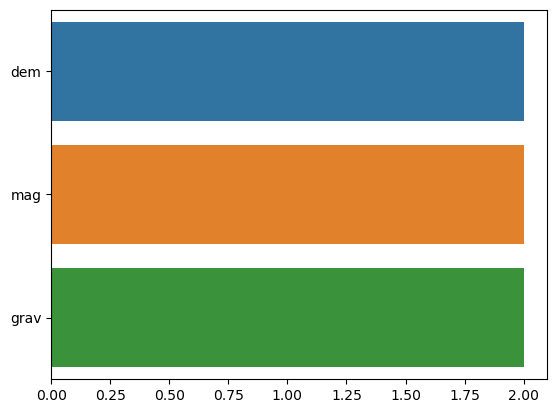

In [42]:
missingNo = fv.isnull().sum(axis = 0).sort_values(ascending = False)
missingNo = missingNo[missingNo.values  > 0]
missingNo

sns.barplot(x=missingNo.values, y=missingNo.index);

In [43]:
import upsetplot

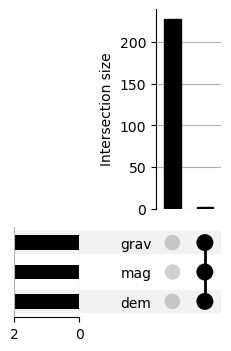

In [44]:
missing_cols = missingNo.index[:5].tolist()
missing_counts = (fv.loc[:, missing_cols]
                  .isnull()
                  .groupby(missing_cols)
                  .size())

upsetplot.plot(missing_counts);

/Users/nbutter/miniconda3/envs/geopy/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


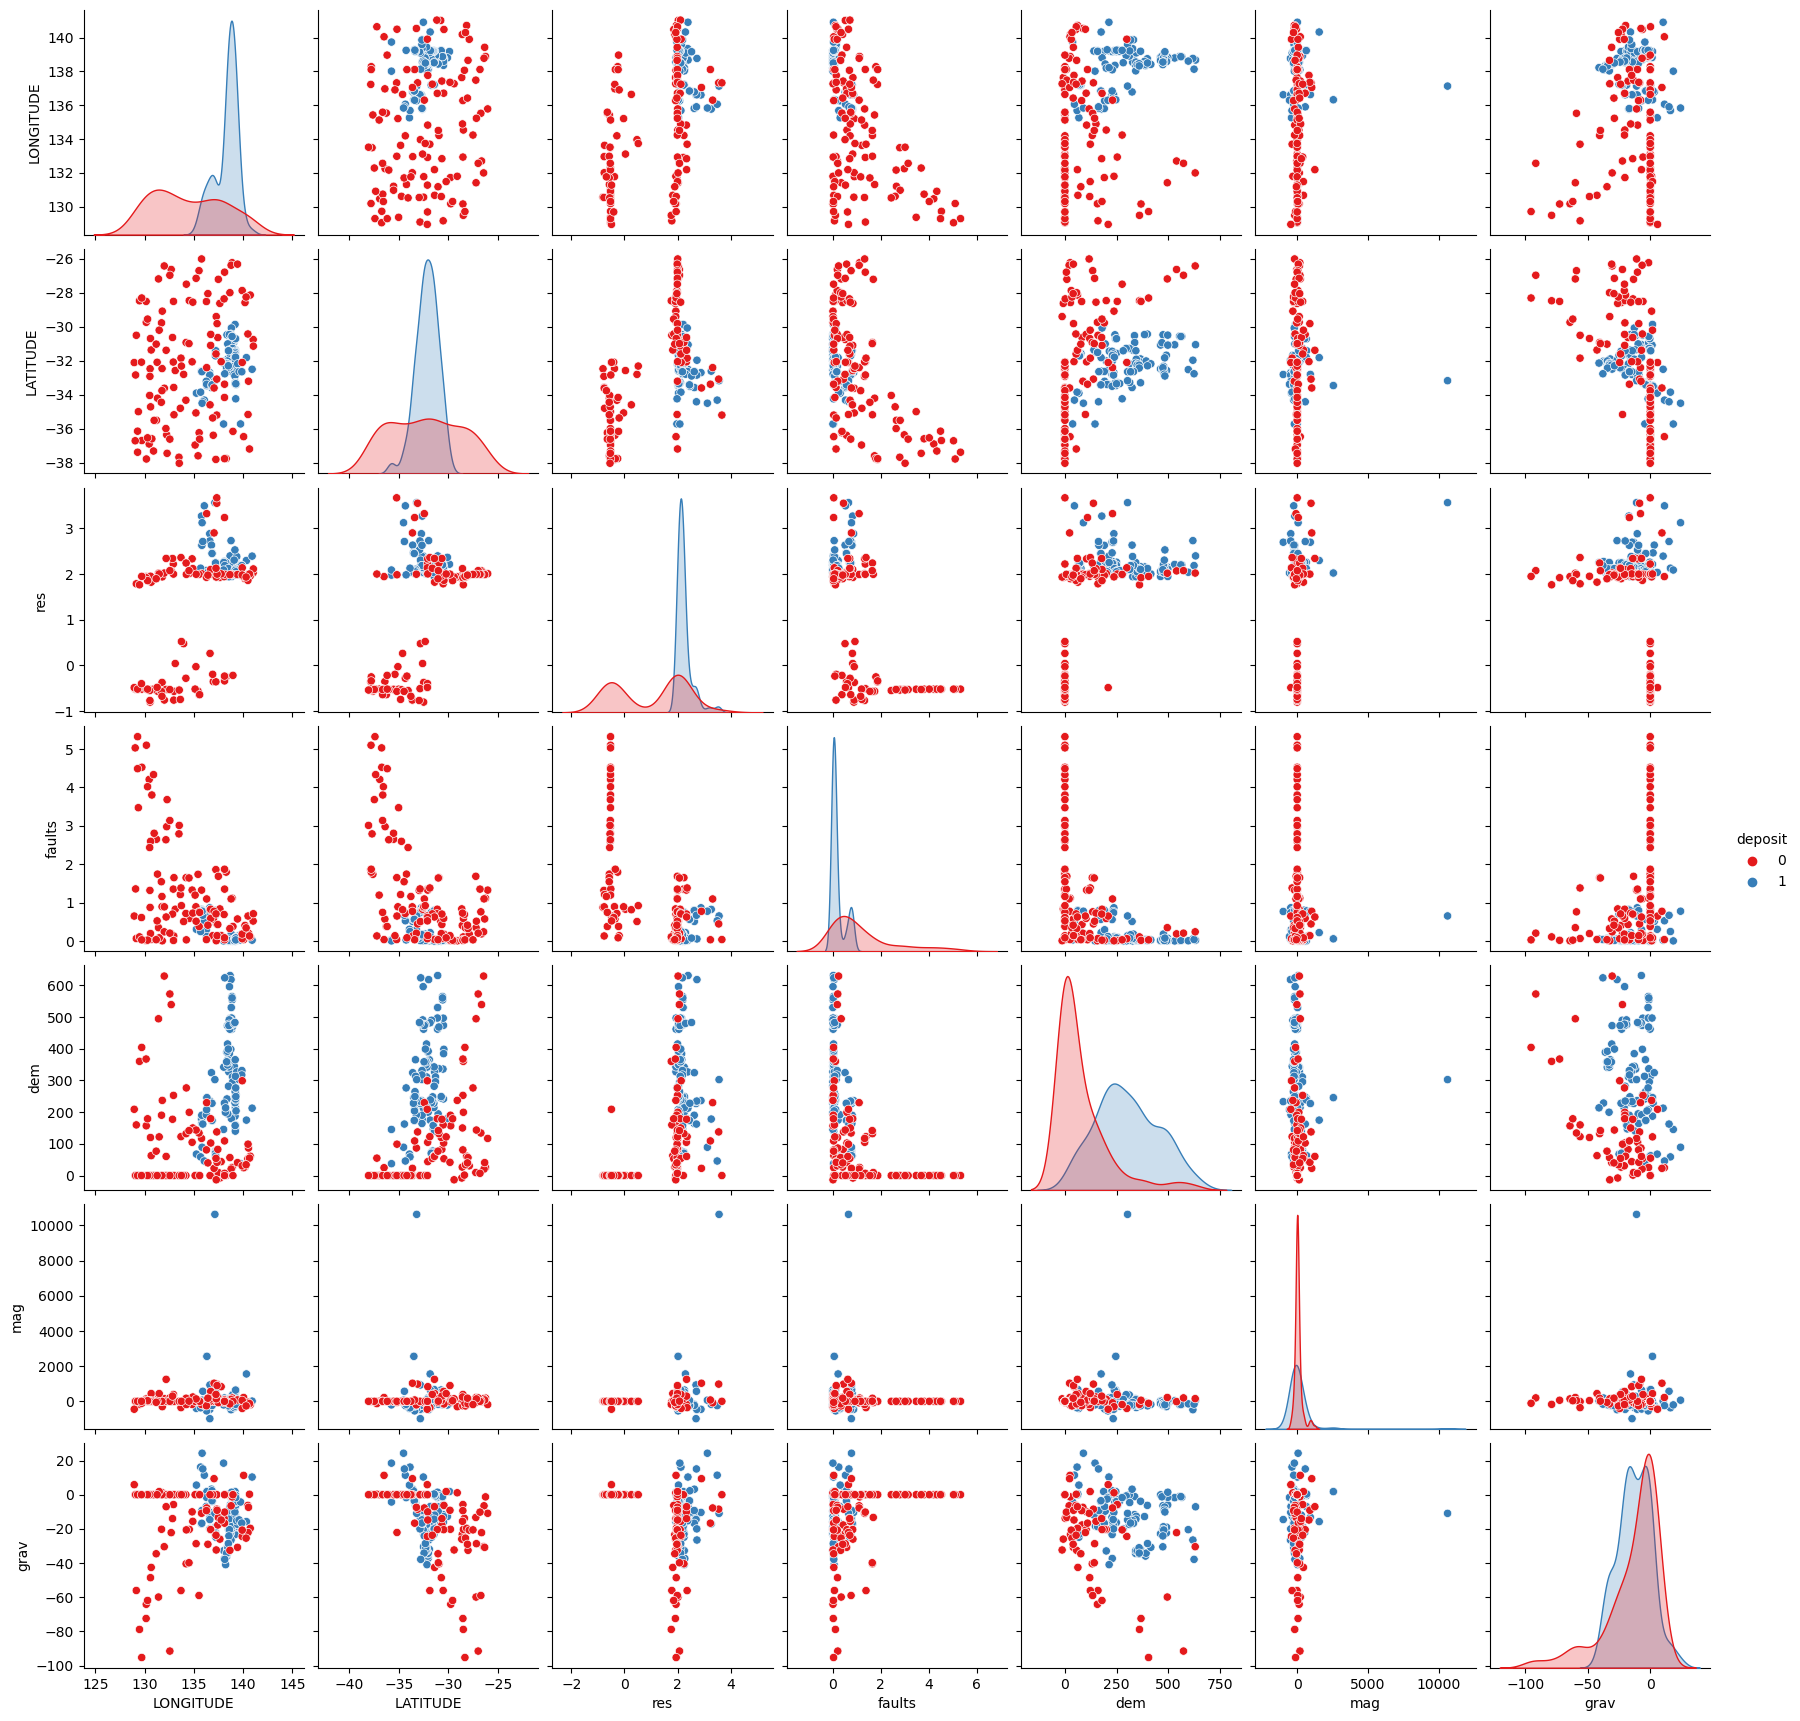

In [45]:
# Plot historgrams and scatter plots for each combination of features.
sns.pairplot(fv,hue='deposit',palette="Set1",diag_kind="auto")

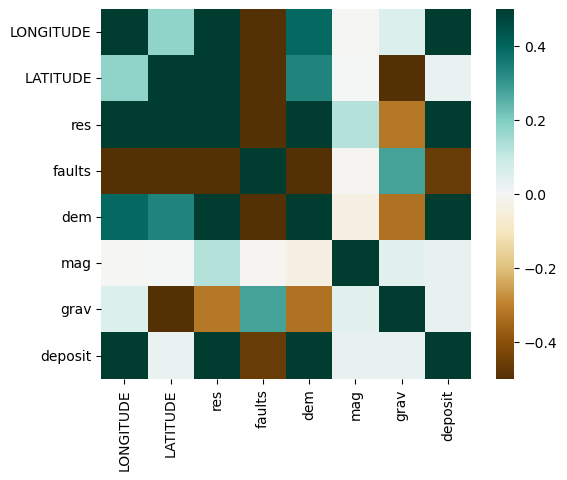

In [46]:
#Plot a heatmap for how correlated each of the features are
corr = fv.select_dtypes(include=['float64', 'int64']).corr() 

sns.heatmap(corr,
            cmap=plt.cm.BrBG, 
            vmin=-0.5, vmax=0.5, 
            square=True,
            xticklabels=True, yticklabels=True,
            );

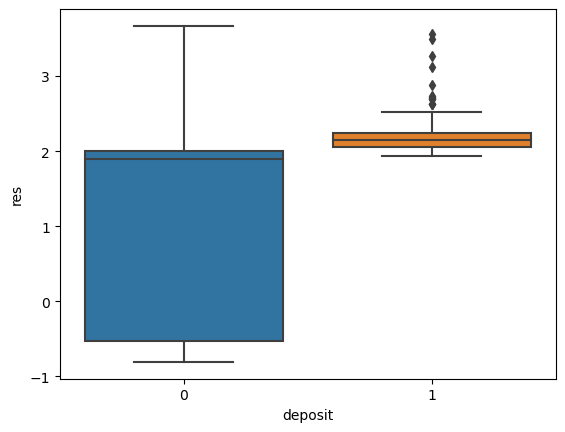

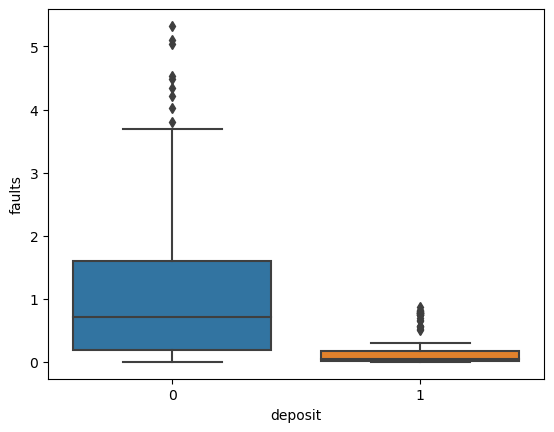

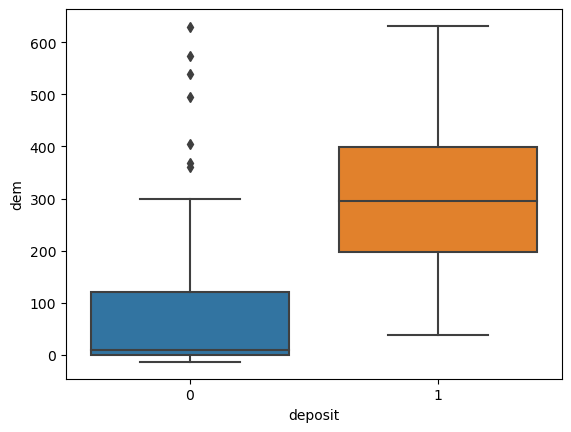

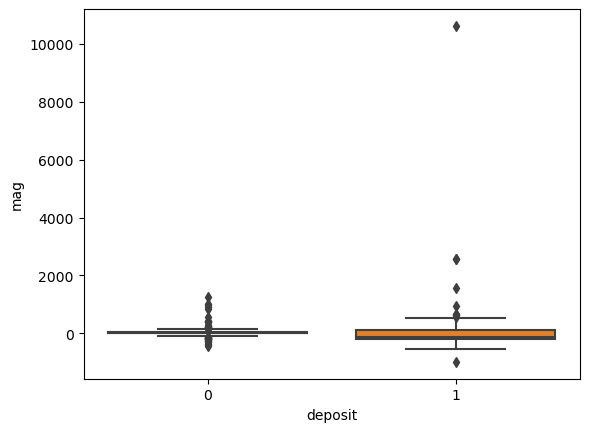

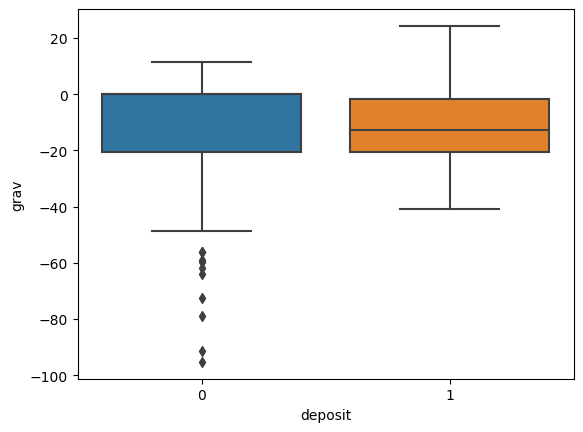

In [47]:
for i in ['res', 'faults', 'dem', 'mag', 'grav']:
    ax = sns.boxplot(x='deposit',y=i, data=fv)
    plt.show()

# Machine Learning

We now have a clean dataset, we know a bit about, let's try and measure some inferences.

### ML Classification
This is where the ML classifier is defined. We can substitue our favourite ML technique here, and tune model variables as desired. As always the [scikit-learn documentation](https://scikit-learn.org/stable/user_guide.html) is a great starting point to learn how these algorithms work.

In [48]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPClassifier

In [49]:
# Create the 'feature vector' and a 'target classification vector'
# Features: Drop the lat/lon, and drop the 'deposit'
features = fv.dropna().iloc[:,2:-1]
# Targets: just the 'deposit' 1/0 binary classified column
targets = fv.dropna().deposit

features.columns

Index(['res', 'faults', 'dem', 'mag', 'grav', 'geol'], dtype='object')

In [50]:
numfts = ['res', 'faults', 'dem', 'mag', 'grav']
catfts = ['geol']

In [51]:
#Create the ML classifier with numerical and categorical data
#Scale, and replace missing values
numeric_transformer = Pipeline(steps=[
    ('imputer',SimpleImputer(missing_values=-9999., strategy='median')),
    ('scaler', StandardScaler())])

#Encode categorical data and fill missing values with default 0
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

#Combine numerical and categorical data
preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_transformer, numfts),
        ('cat', categorical_transformer, catfts)])

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
rf = Pipeline(steps=[('preprocessor', preprocessor),
                ('classifier', RandomForestClassifier(random_state=1))])
                #('classifier', MLPClassifier(solver='adam', alpha=0.001, max_iter=10000))])


RF 5-fold cross validation Scores: [0.95652174 0.89130435 0.97826087 0.93333333 0.75555556]
SCORE Mean: 0.90 STD: 0.08 



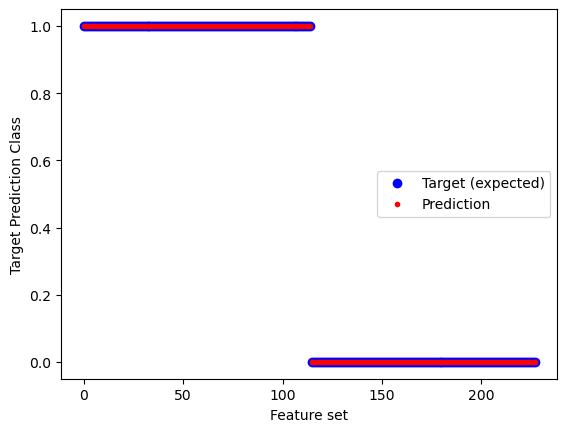

In [52]:
# Train the classifier! That is it, we have made our ML model.
rf.fit(features,targets)

# Now see how well it performs with a "cross-fold validation"
scores = cross_val_score(rf, features,targets, cv=5)

print("RF 5-fold cross validation Scores:", scores)
print("SCORE Mean: %.2f" % np.mean(scores), "STD: %.2f" % np.std(scores), "\n")

plt.plot(targets.values,'bo',label='Target (expected)')
plt.plot(rf.predict(features),'r.',label='Prediction')
plt.xlabel("Feature set")
plt.ylabel("Target Prediction Class")
plt.legend(loc=7)

In [53]:
print("Features:",np.shape(features),"Targets:",np.shape(targets))
print("RF CV-Scores: ",scores)
print("CV-SCORE Mean: %.2f" % np.mean(scores), "STD: %.2f" % np.std(scores))
#print("OOB score:",rf.steps[-1][1].oob_score_)

print("Targets (expected result):")
print(targets.values)
print("Prediction (actual result):")
print(rf.predict(features))

Features: (228, 6) Targets: (228,)
RF CV-Scores:  [0.95652174 0.89130435 0.97826087 0.93333333 0.75555556]
CV-SCORE Mean: 0.90 STD: 0.08
Targets (expected result):
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0]
Prediction (actual result):
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

In [54]:
# Gather the importance measures
ft_imp = []
ft_lab = []

for i,lab in enumerate(np.append(numfts,rf['preprocessor'].transformers_[1][1]['onehot'].get_feature_names_out(catfts))):
    ft_imp.append(rf.steps[-1][1].feature_importances_[i])
    ft_lab.append(lab)

From the Random Forest ML algorithm
these are the the most significant features for predicting the target bins.



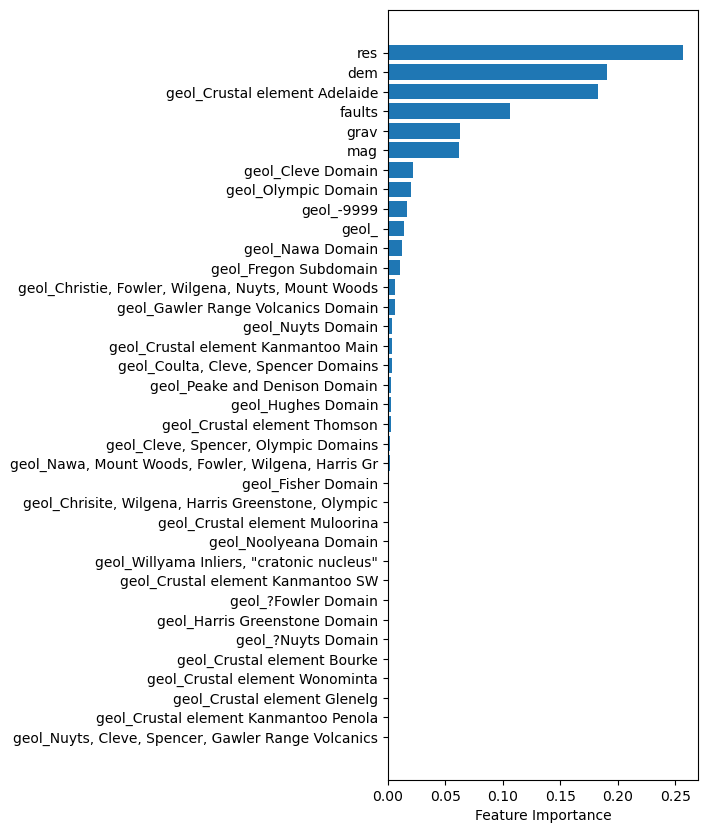

In [55]:
#Make the bar plot
ft_imps, ft_labs = (list(t) for t in zip(*sorted(zip(ft_imp,ft_lab))))
datalength = len(ft_imp)

#Create a new figure
fig,ax = plt.subplots(figsize=(4,10))

#Plot the bar graph
rects = ax.barh(np.arange(0, datalength, step=1),ft_imps)
ax.set_yticks(np.arange(0, datalength, step=1))
ax.set_yticklabels(ft_labs)
ax.set_xlabel('Feature Importance')
print("From the Random Forest ML algorithm\nthese are the the most significant features for predicting the target bins.\n")

plt.show()

# Find where to dig!

Now we have a trained model we can pass it NEW data, that is values for all the geopysical parameters, and it will give us a prediction for whether there is a deposit there or not. Simple.

In [56]:
res1 = [2.2,2.2]
faults1 = [0.01,2.2]
dem1 = [187,2.2]
mag1 = [-118,2.2]
grav = [1.8,2.2]
geol = ['Crustal element Adelaide','Crustal element Muloorina']

targets = pd.DataFrame({'res':res1,'faults':faults1,'dem':dem1,'mag':mag1,'grav':grav,'geol':geol})
targets_scaled = targets
# targets_scaled = rf.named_steps['preprocessor'].transform(targets)

print(targets)
print(targets_scaled)
rf.predict_proba(targets_scaled)

   res  faults    dem    mag  grav                       geol
0  2.2    0.01  187.0 -118.0   1.8   Crustal element Adelaide
1  2.2    2.20    2.2    2.2   2.2  Crustal element Muloorina
   res  faults    dem    mag  grav                       geol
0  2.2    0.01  187.0 -118.0   1.8   Crustal element Adelaide
1  2.2    2.20    2.2    2.2   2.2  Crustal element Muloorina


array([[0.  , 1.  ],
       [0.78, 0.22]])

In [57]:
# Better - Make a grid of target locations over an entire area
#100x100 takes about 1 minute
grid_x, grid_y = np.mgrid[130:140:100j,-36:-26:100j]

# Now we want to get the geophys values for every single point on this grid
# Which we will then apply our model to!

In [58]:
%%time

tdf = pd.DataFrame({'LONGITUDE': grid_x.reshape(grid_x.size), 'LATITUDE': grid_y.reshape(grid_y.size)})
# tdf = rf['preprocessor'].transform(tdf)

# Res
indexes = tdf.apply(
    lambda x: coregPoint(treeres,np.array([x.LONGITUDE, x.LATITUDE]),10,retval='index'), axis=1)

tdf['res'] = data_res.loc[indexes].resistivity.values
print("Done res")

# Faults
tdf['faults'] = tdf.apply(
    lambda x: coregPoint(treefaults,np.array([x.LONGITUDE, x.LATITUDE]),100,retval='dists'), axis=1)
print("Done faults")

# Geophys
tdf['dem'] = rastersearch(tdf,data_dem["z_data"],data_dem["origin_x"],data_dem["origin_y"],data_dem["pixel_x"],data_dem["pixel_y"])
tdf['mag'] = rastersearch(tdf,data_mag["z_data"],data_mag["origin_x"],data_mag["origin_y"],data_mag["pixel_x"],data_mag["pixel_y"])
tdf['grav'] = rastersearch(tdf,data_grav["z_data"],data_grav["origin_x"],data_grav["origin_y"],data_grav["pixel_x"],data_grav["pixel_y"])
print("Done rasters")

# Geology
tdf['geol'] = tdf.apply(lambda x: shapeExplore(x.LONGITUDE, x.LATITUDE, shape_objects,recsArch), axis=1)
print("Done!")

Done res
Done faults
Done rasters
Done!
CPU times: user 1min 54s, sys: 466 ms, total: 1min 55s
Wall time: 1min 55s


In [59]:
# Save all our hard work to a csv file for more hacking to come!
tdf.to_csv('../data/tdf_100.csv',index=False)
# tdf = pd.read_csv('../data/tdf_100.csv') #Read the file in if you need

In [60]:
#Apply the trained ML to our gridded data to determine the probabilities at each of the points
print('RF...')
pRF_map=np.array(rf.predict_proba(tdf.iloc[:,2:]))
print("Done RF")

RF...
Done RF


In [61]:
#X, Y = np.meshgrid(xi, yi)
gridZ = scipy.interpolate.griddata((tdf.LONGITUDE, tdf.LATITUDE), pRF_map[:,1], (grid_x, grid_y),method='linear')

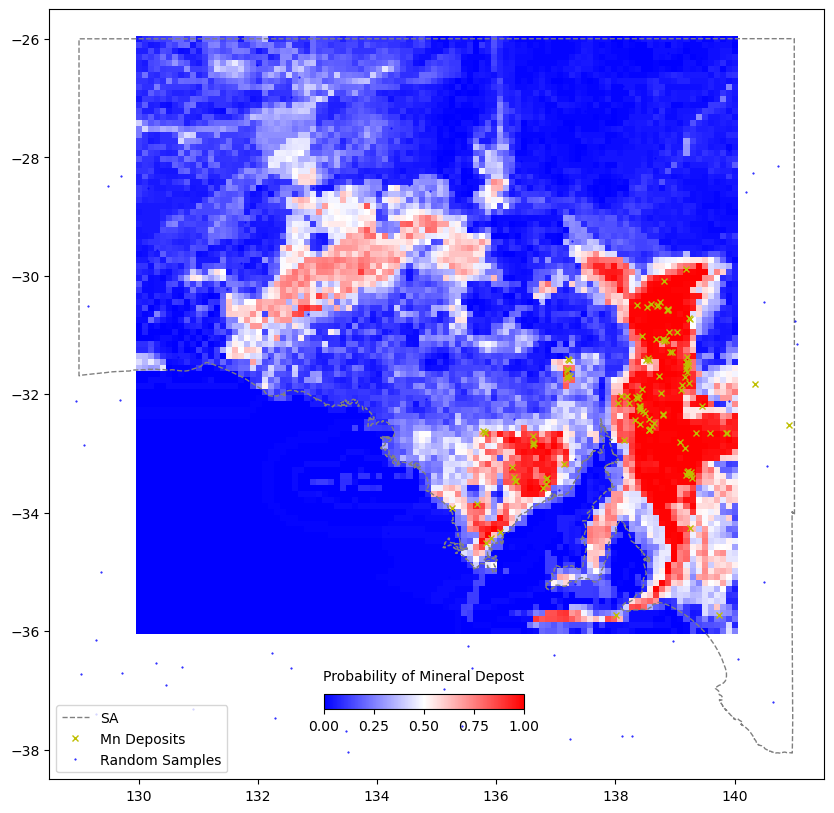

In [62]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes()
im = plt.pcolormesh(grid_x,grid_y,gridZ,cmap='bwr',shading='auto')
ax.plot(xval,yval,'grey',linestyle='--',linewidth=1,label='SA')
ax.plot(fv[fv.deposit==1].LONGITUDE, fv[fv.deposit==1].LATITUDE, 
        marker='x', linestyle='',markersize=5, color='y',label=commname+" Deposits")
ax.plot(fv[fv.deposit==0].LONGITUDE, fv[fv.deposit==0].LATITUDE, 
        marker='.', linestyle='',markersize=1, color='b',label="Random Samples")

plt.xlim(128.5,141.5)
plt.ylim(-38.5,-25.5)
plt.legend(loc=3)

cbaxes = fig.add_axes([0.40, 0.18, 0.2, 0.015])
cbar = plt.colorbar(im, cax = cbaxes,orientation="horizontal")
cbar.set_label('Probability of Mineral Depost', labelpad=10)
cbar.ax.xaxis.set_label_position('top')

plt.show()